In [1]:
%matplotlib widget
import numpy as np
import obspy
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
from scipy.signal import spectrogram
import datetime

In [2]:
# set path and data parameters
path = "/media/Data/Data/PIG/"
stat = "PIG*"
chans = "HH*"

# set path to XML response file
pathXML = path + "XML/" + chans + "/*" + stat + ".xml"
inv = obspy.read_inventory(pathXML)

In [ ]:
'''

Read data, remove instrumental response, and basic preprocessing for entire window constrained by TerraSAR-X data

'''

# set day of interest
year = "2012"
month = "05"
days = ["08","09","10","11"]

# read in traces without instrument response removed
files = [path + "MSEED/raw/" + stat + "/" + chans + "/*" + chans + "__" + year + month + day + "T000000Z__" + "*" for day in days]

# read in raw data
st_raw = obspy.Stream()
for f in files:
    st_raw += obspy.read(f)

# merge streams from corresponding stations and channels
st_raw.merge()
    
# basic preprocessing
st_raw.detrend("demean")
st_raw.detrend("linear")
st_raw.taper(max_percentage=0.00025, max_length=20.)

# remove response to each desired frequency
st_1000s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.0005,0.001,0.5,1],output="VEL")
st_100s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.005,0.01,0.5,1],output="VEL")
st_10s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.05,0.1,45,50],output="VEL")

# downsample to increase speed
st_raw_downsampled = st_raw.resample(1)
st_10s_downsampled = st_10s.resample(1)
st_100s_downsampled = st_100s.resample(1)
st_1000s_downsampled = st_1000s.resample(1)

# save outputs
st_raw_downsampled.write("data/MSEED/may_8-11_velocity_raw_downsampled.MSEED")
st_10s_downsampled.write("data/MSEED/may_8-11_velocity_10s_downsampled.MSEED")
st_100s_downsampled.write("data/MSEED/may_8-11_velocity_100s_downsampled.MSEED")
st_1000s_downsampled.write("data/MSEED/may_8-11_velocity_1000s_downsampled.MSEED")

In [ ]:
'''

Read data, remove instrumental response, and basic preprocessing for investigating scaling between frequency and key event parameters 

'''

# read in traces without instrument response removed
files = path + "MSEED/raw/" + stat + "/" + chans + "/*" + chans + "__20120509T000000Z__" + "*"

# read in raw data
st_raw = obspy.read(files)

# trim to speed up instrument response removal
st_raw = st_raw.trim(starttime=obspy.UTCDateTime(2012,5,9,17),endtime=obspy.UTCDateTime(2012,5,9,23,59))

# basic preprocessing
st_raw.detrend("demean")
st_raw.detrend("linear")
st_raw.taper(max_percentage=0.00025, max_length=20.)

# remove response to each desired frequency
st_100000s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.000005,0.00001,45,50],output="VEL")
st_10000s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.00005,0.0001,45,50],output="VEL")
st_1000s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.0005,0.001,45,50],output="VEL")
st_100s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.005,0.01,45,50],output="VEL")
st_10s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.05,0.1,45,50],output="VEL")
st_1s = st_raw.copy().remove_response(inventory=inv,pre_filt=[0.5,1,45,50],output="VEL")

# save outputs
st_raw.write("data/MSEED/may_9_event_velocity_raw.MSEED")
st_1s.write("data/MSEED/may_9_event_velocity_1s.MSEED")
st_10s.write("data/MSEED/may_9_event_velocity_10s.MSEED")
st_100s.write("data/MSEED/may_9_event_velocity_100s.MSEED")
st_1000s.write("data/MSEED/may_9_event_velocity_1000s.MSEED")
st_10000s.write("data/MSEED/may_9_event_velocity_10000s.MSEED")
st_100000s.write("data/MSEED/may_9_event_velocity_10000s.MSEED")

/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide


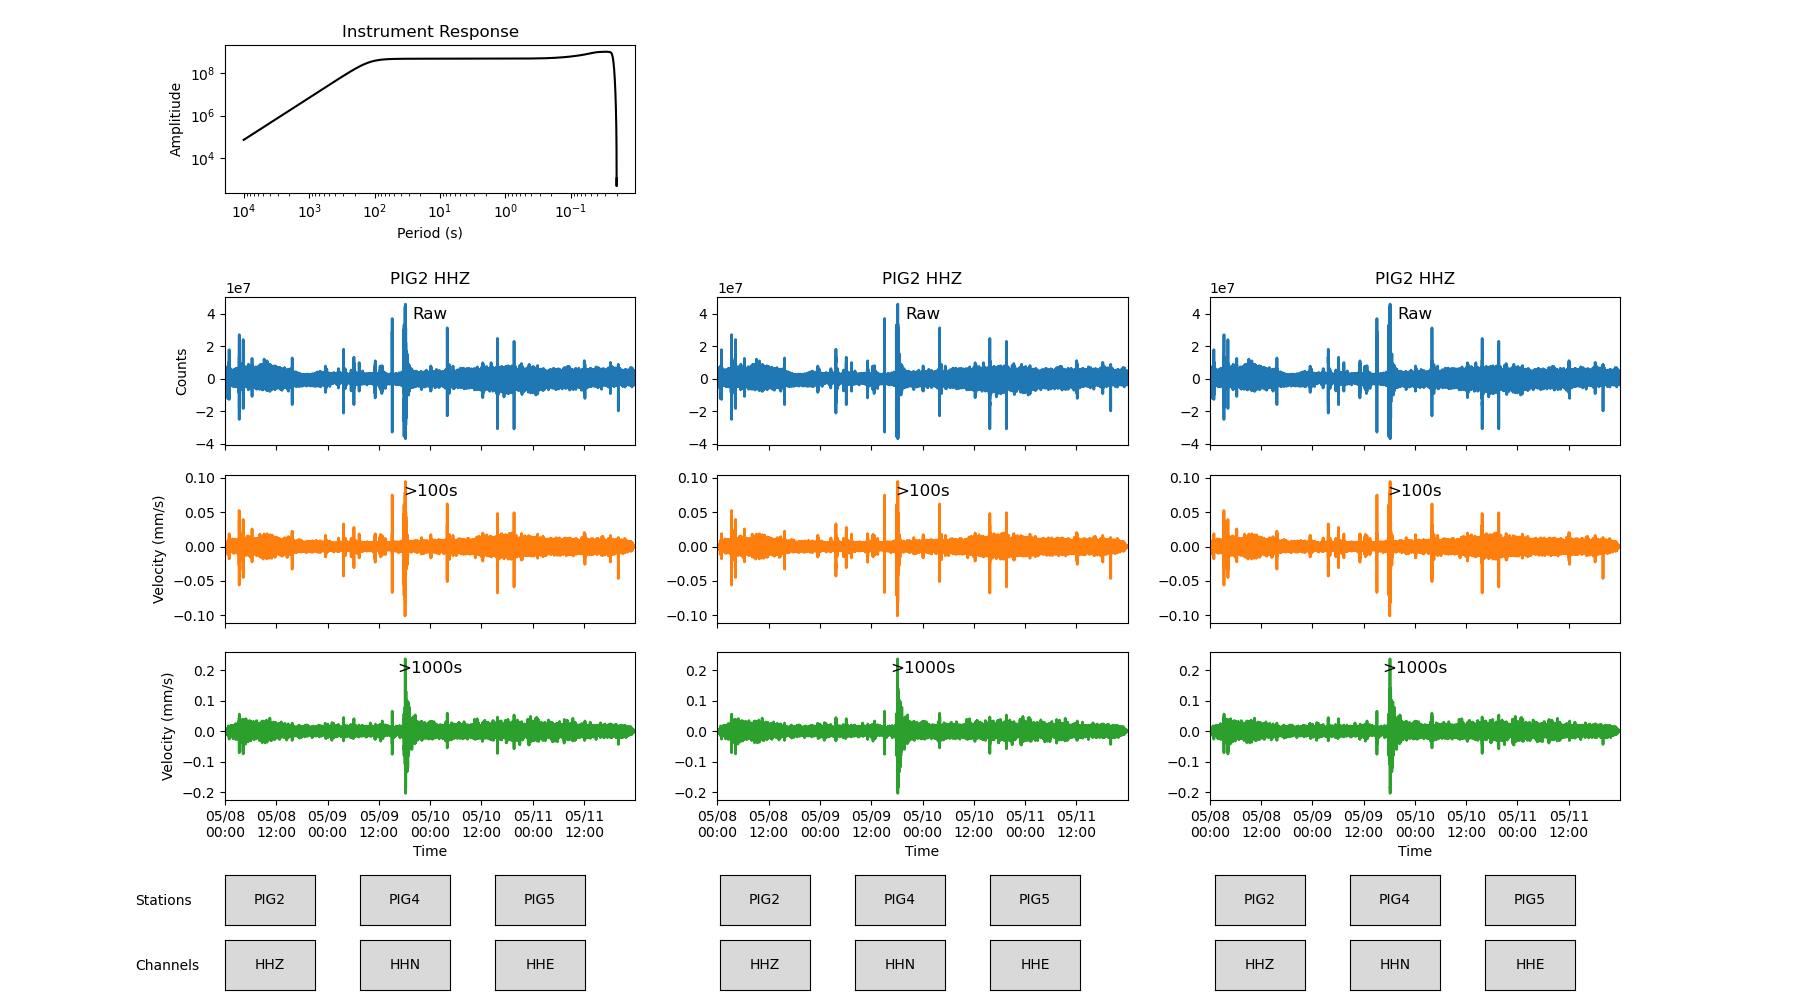

In [6]:
'''

Make interactive plot for comparing data across stations and channels

'''

# get data
st_raw = obspy.read("data/MSEED/may_8-11_velocity_raw_downsampled.MSEED")
st_100s = obspy.read("data/MSEED/may_8-11_velocity_100s_downsampled.MSEED")
st_1000s = obspy.read("data/MSEED/may_8-11_velocity_1000s_downsampled.MSEED")

# put data into dictionary
#window_start = obspy.UTCDateTime(2012,5,9,17)
#window_end = obspy.UTCDateTime(2012,5,9,23)
window_start = obspy.UTCDateTime(2012,5,8)
window_end = obspy.UTCDateTime(2012,5,11,23,59)
data_raw_dict = {}
data_100s_dict = {}
data_1000s_dict = {}
for tr in st_raw:
    key = tr.stats.station+tr.stats.channel
    data_raw_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_100s:
    key = tr.stats.station+tr.stats.channel
    data_100s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000
for tr in st_1000s:
    key = tr.stats.station+tr.stats.channel
    data_1000s_dict[key] = tr.trim(starttime=window_start,endtime=window_end).data*1000

# get time vector
t = st_raw[1].times(type="matplotlib")

# get response
inv = obspy.read_inventory("data/XML/*.XML")

# define object for updating data when buttons are pressed
class metadata:
    station = "PIG2"
    channel = "HHZ"
    
    def select_channel(self,channel,column):
        def clicked(event):
            self.channel = channel
            ax[1][column].get_lines()[0].set_ydata(data_raw_dict[self.station+self.channel])
            ax[2][column].get_lines()[0].set_ydata(data_100s_dict[self.station+self.channel])
            ax[3][column].get_lines()[0].set_ydata(data_1000s_dict[self.station+self.channel])
            ax[1][column].set_title(self.station+" "+self.channel+"\n\nRaw",y=0.8)
            for axis in ax.transpose()[column][1:]:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
    def select_station(self,station,column):
        def clicked(event):
            self.station = station
            ax[1][column].get_lines()[0].set_ydata(data_raw_dict[self.station+self.channel])
            ax[2][column].get_lines()[0].set_ydata(data_100s_dict[self.station+self.channel])
            ax[3][column].get_lines()[0].set_ydata(data_1000s_dict[self.station+self.channel])
            ax[1][column].set_title(self.station+" "+self.channel+"\n\nRaw",y=0.8)
            for axis in ax.transpose()[column][1:]:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
# make plot
fig,ax = plt.subplots(4,3,figsize=[18,10])
plt.subplots_adjust(bottom=0.2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plot the data
for axis in ax[1]:
    axis.plot(t,data_raw_dict["PIG2HHZ"], lw=2,color=colors[0])
    axis.set_title("PIG2 HHZ\n\nRaw",y=0.8)
for axis in ax[2]:
    axis.plot(t,data_100s_dict["PIG2HHZ"], lw=2,color=colors[1])
    axis.set_title(">100s",y=0.8)
for axis in ax[3]:
    axis.plot(t,data_1000s_dict["PIG2HHZ"], lw=2,color=colors[2])
    axis.set_title(">1000s",y=0.8)

# plot instrumental response
sampling_rate = 100
min_freq = 0.0001
t_samp = 1.0 / sampling_rate
nyquist = sampling_rate / 2.0
nfft = int(sampling_rate / min_freq)
response = inv.select(channel="HHZ",station="PIG2")[0][0][0].response
cpx_response, freq = response.get_evalresp_response(t_samp=t_samp, nfft=nfft)
plot_resp, = ax[0][0].loglog(1/freq,abs(cpx_response),'k')
ax[0][0].set(title="Instrument Response")
ax[0][0].invert_xaxis()
ax[0][0].set_xlabel("Period (s)")
box = ax[0][0].get_position()
box.y0 = box.y0 + 0.075
box.y1 = box.y1 + 0.075
ax[0][0].set_position(box)
ax[0][1].set_visible(0)
ax[0][2].set_visible(0)

# make instances of the widget
column0 = metadata()
column1 = metadata()
column2 = metadata()

# configure labels and limits
ax[0][0].set_ylabel("Amplitiude")
ax[1][0].set_ylabel("Counts")
ax[2][0].set_ylabel("Velocity (mm/s)")
ax[3][0].set_ylabel("Velocity (mm/s)")
for i in range(1,4):
    for axis in ax[i]:
        axis.get_xaxis().set_ticklabels([])
        axis.set_xlim([t[0],t[-1]])
        if i == 3:
            axis.set_xlabel("Time")
            axis.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
for i in range(3):
    ax[3][i].get_shared_x_axes().join(ax[3][i],ax[1][i])
    ax[3][i].get_shared_x_axes().join(ax[3][i],ax[2][i])
    
# add each set of buttons
axbutton = plt.axes([0.125, 0.075, 0.05, 0.05])
pig2_b0 = Button(axbutton, 'PIG2')
pig2_b0.on_clicked(column0.select_station("PIG2",0))
axbutton = plt.axes([0.2, 0.075, 0.05, 0.05])
pig4_b0 = Button(axbutton, 'PIG4')
pig4_b0.on_clicked(column0.select_station("PIG4",0))
axbutton = plt.axes([0.275, 0.075, 0.05, 0.05])
pig5_b0 = Button(axbutton, 'PIG5')
pig5_b0.on_clicked(column0.select_station("PIG5",0))
plt.text(-4,0.4,"Stations")
axbutton = plt.axes([0.125, 0.01, 0.05, 0.05])
hhz_b0 = Button(axbutton, 'HHZ')
hhz_b0.on_clicked(column0.select_channel("HHZ",0))
axbutton = plt.axes([0.2, 0.01, 0.05, 0.05])
hhn_b0 = Button(axbutton, 'HHN')
hhn_b0.on_clicked(column0.select_channel("HHN",0))
axbutton = plt.axes([0.275, 0.01, 0.05, 0.05])
hhe_b0 = Button(axbutton, 'HHE')
hhe_b0.on_clicked(column0.select_channel("HHE",0))
plt.text(-4,0.4,"Channels")

# second set of buttons
axbutton = plt.axes([0.125+0.275, 0.075, 0.05, 0.05])
pig2_b1 = Button(axbutton, 'PIG2')
pig2_b1.on_clicked(column1.select_station("PIG2",1))
axbutton = plt.axes([0.2+0.275, 0.075, 0.05, 0.05])
pig4_b1 = Button(axbutton, 'PIG4')
pig4_b1.on_clicked(column1.select_station("PIG4",1))
axbutton = plt.axes([0.275+0.275, 0.075, 0.05, 0.05])
pig5_b1 = Button(axbutton, 'PIG5')
pig5_b1.on_clicked(column1.select_station("PIG5",1))
axbutton = plt.axes([0.125+0.275, 0.01, 0.05, 0.05])
hhz_b1 = Button(axbutton, 'HHZ')
hhz_b1.on_clicked(column1.select_channel("HHZ",1))
axbutton = plt.axes([0.2+0.275, 0.01, 0.05, 0.05])
hhn_b1 = Button(axbutton, 'HHN')
hhn_b1.on_clicked(column1.select_channel("HHN",1))
axbutton = plt.axes([0.275+0.275, 0.01, 0.05, 0.05])
hhe_b1 = Button(axbutton, 'HHE')
hhe_b1.on_clicked(column1.select_channel("HHE",1))

# third set of buttons
axbutton = plt.axes([0.125+2*(0.275), 0.075, 0.05, 0.05])
pig2_b2 = Button(axbutton, 'PIG2')
pig2_b2.on_clicked(column2.select_station("PIG2",2))
axbutton = plt.axes([0.2+2*(0.275), 0.075, 0.05, 0.05])
pig4_b2 = Button(axbutton, 'PIG4')
pig4_b2.on_clicked(column2.select_station("PIG4",2))
axbutton = plt.axes([0.275+2*(0.275), 0.075, 0.05, 0.05])
pig5_b2 = Button(axbutton, 'PIG5')
pig5_b2.on_clicked(column2.select_station("PIG5",2))
axbutton = plt.axes([0.125+2*(0.275), 0.01, 0.05, 0.05])
hhz_b2 = Button(axbutton, 'HHZ')
hhz_b2.on_clicked(column2.select_channel("HHZ",2))
axbutton = plt.axes([0.2+2*(0.275), 0.01, 0.05, 0.05])
hhn_b2 = Button(axbutton, 'HHN')
hhn_b2.on_clicked(column2.select_channel("HHN",2))
axbutton = plt.axes([0.275+2*(0.275), 0.01, 0.05, 0.05])
hhe_b2 = Button(axbutton, 'HHE')
hhe_b2.on_clicked(column2.select_channel("HHE",2))

plt.show()

/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


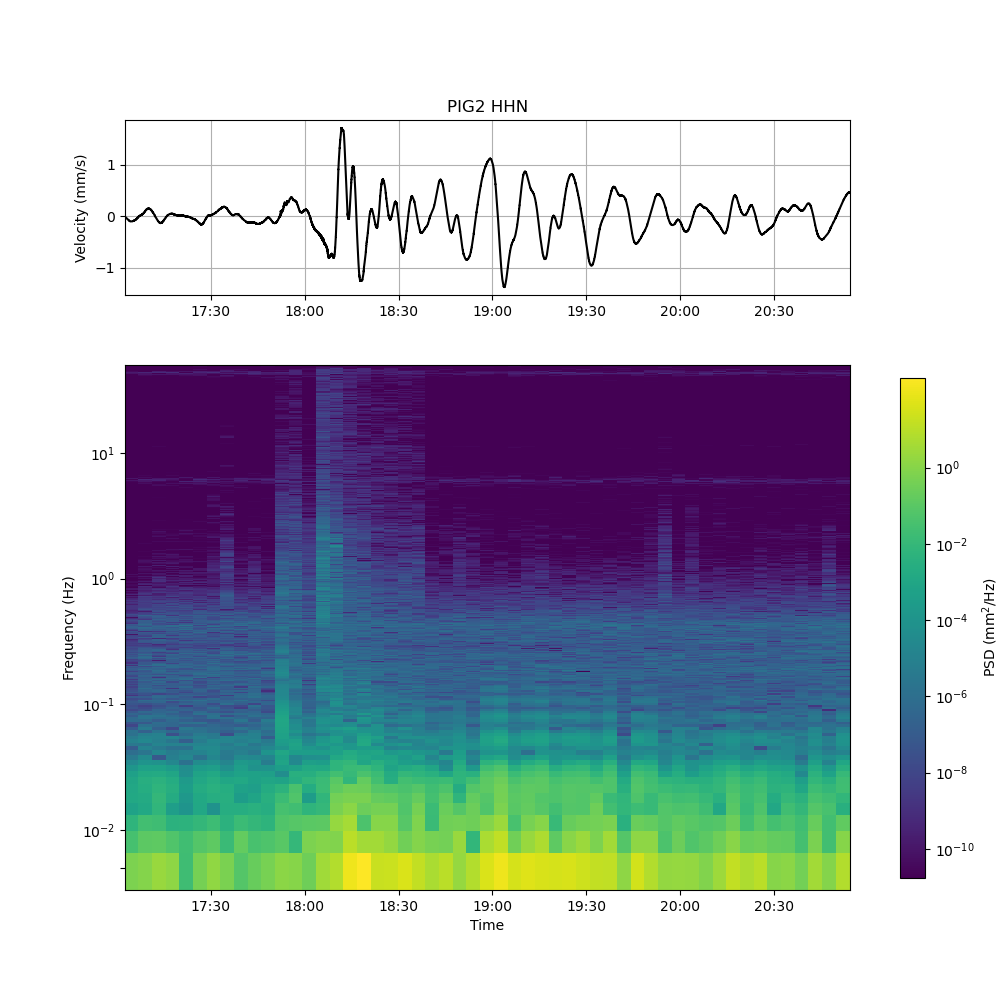

In [7]:
'''

Make spectrogram of the event

'''

# set parameters
station = "PIG2"
channel = "HHN"

# make spectrogram
st_1000s = obspy.read("data/MSEED/may_9_event_velocity_1000s.MSEED")
st_1000s = st_1000s.trim(starttime=obspy.UTCDateTime(2012,5,9,17),endtime=obspy.UTCDateTime(2012,5,9,21))
f,t,s = spectrogram(st_1000s.select(station=station,channel=channel)[0].data, fs=100.0, nperseg=30000)

# make plot
fig,ax = plt.subplots(2,1,figsize=[10,10],gridspec_kw={'height_ratios': [1, 3]})

# plot data
times = [t.datetime for t in st_1000s[2].times("UTCDateTime")]
ticks = [times[len(times)//8],times[len(times)//4],times[len(times)//8*3],times[len(times)//2],times[len(times)//8*5],times[len(times)//4*3],times[len(times)//8*7],times[len(times)-1]]
ax[0].plot(times,st_1000s.select(channel=channel,station=station)[0].data*1000,'k')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].grid(True)
box = ax[0].get_position()
box.y0 = box.y0 - 0.1
box.y1 = box.y1 - 0.1
ax[0].set_position(box)
ax[0].set_ylabel("Velocity (mm/s)")    
ax[0].set_title(station+" "+channel)
# make spectrogram
st_1000s = obspy.read("data/MSEED/may_9_event_velocity_1000s.MSEED")
st_1000s = st_1000s.trim(starttime=obspy.UTCDateTime(2012,5,9,17),endtime=obspy.UTCDateTime(2012,5,9,21))
f,t,s = spectrogram(st_1000s.select(station=station,channel=channel)[0].data*1000, fs=100.0, nperseg=30000)

# plot spectrogram 
times = [datetime.datetime(2012,5,9,17) + datetime.timedelta(seconds=time) for time in t]
vrange = np.log10(np.max(s))-np.log10(np.min(s))
spec = ax[1].pcolor(times, np.log10(f), np.log10(s), vmin=np.log10(np.min(s))+vrange*0.5,vmax=np.log10(np.max(s)))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].get_shared_x_axes().join(ax[0],ax[1])
ax[1].set_xticks(ticks)
ax[1].set_xlim([times[0],times[-1]])
ax[1].set_yticks([-2.3,-2,-1,0,1])
ax[1].set_yticklabels(["","$10^{-2}$","$10^{-1}$","$10^{0}$","$10^{1}$"])
ax[1].set_ylabel("Frequency (Hz)")
ax[1].set_xlabel("Time")
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.1225, 0.025, 0.5])
cbar = plt.colorbar(spec,label="PSD (mm$^2$/Hz)",ticks=[-10,-8,-6,-4,-2,0],cax=cbar_ax)
cbar.ax.set_yticklabels(['$10^{-10}$', '$10^{-8}$', '$10^{-6}$', '$10^{-4}$','$10^{-2}$','$10^0$']) 
plt.savefig(station + "_" + channel + "_spectrogram.png")

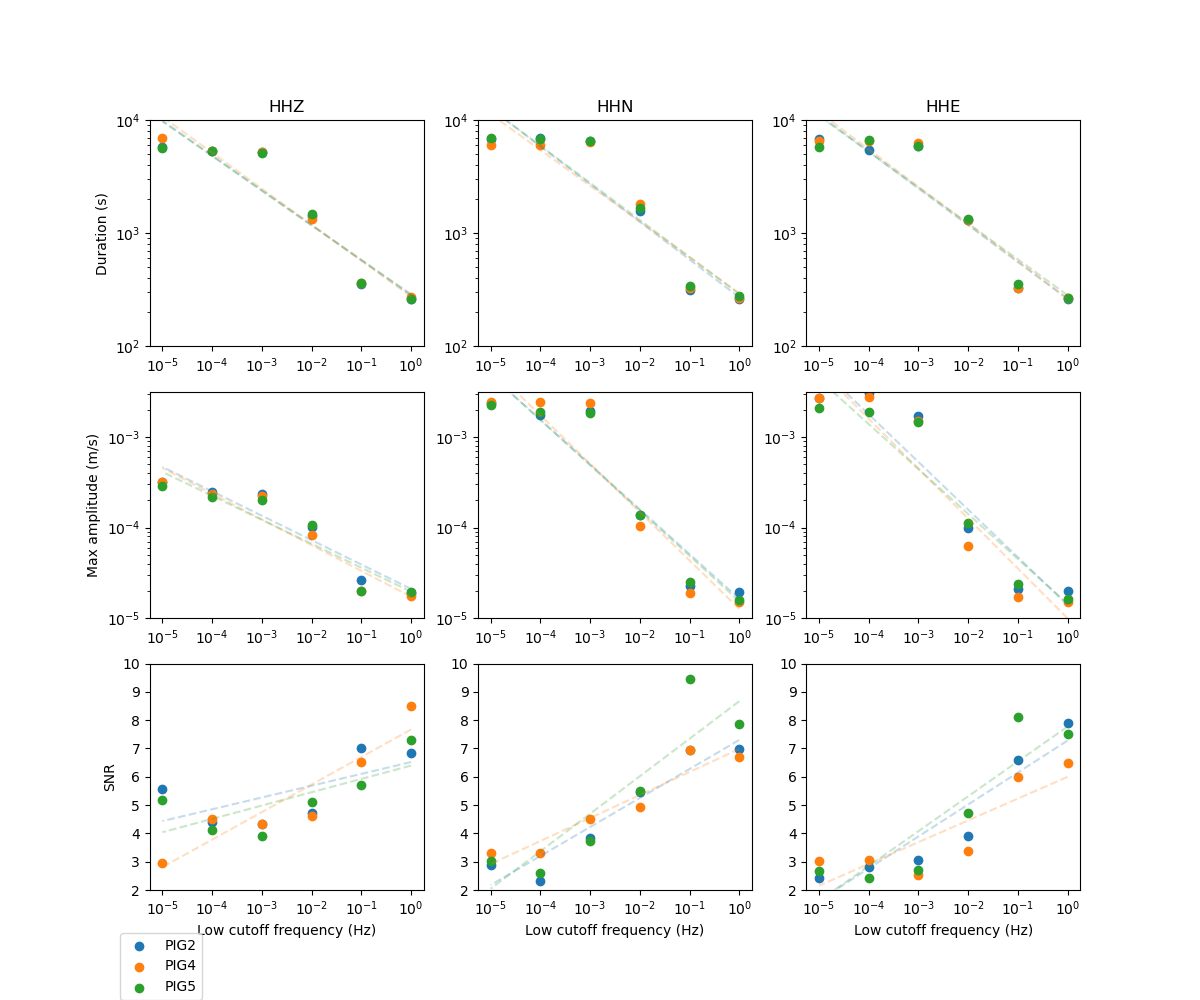

In [9]:
'''

Investigate relationships between frequency and duration, SNR, and amplitude

'''

# get data
st_1s = obspy.read("data/MSEED/may_9_event_velocity_1s.MSEED")
st_10s = obspy.read("data/MSEED/may_9_event_velocity_10s.MSEED")
st_100s = obspy.read("data/MSEED/may_9_event_velocity_100s.MSEED")
st_1000s = obspy.read("data/MSEED/may_9_event_velocity_1000s.MSEED")
st_10000s = obspy.read("data/MSEED/may_9_event_velocity_10000s.MSEED")
st_100000s = obspy.read("data/MSEED/may_9_event_velocity_100000s.MSEED")

# set parameters 
stations = ["PIG2","PIG4","PIG5"]
channels = ["HHZ","HHE","HHN"]
low_cut = [1,0.1,0.01,0.001,0.0001,0.00001]
fs = 100
window_start = obspy.UTCDateTime(2012,5,9,18,2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# put data into dictionary
data_dict = {}
for tr in st_1s:
    key = tr.stats.station+tr.stats.channel+"1"
    data_dict[key] = tr.trim(starttime=window_start,endtime=obspy.UTCDateTime(2012,5,9,18,10)).data
for tr in st_10s:
    key = tr.stats.station+tr.stats.channel+"10"
    data_dict[key] = tr.trim(starttime=window_start,endtime=obspy.UTCDateTime(2012,5,9,18,10)).data
for tr in st_100s:
    key = tr.stats.station+tr.stats.channel+"100"
    data_dict[key] = tr.trim(starttime=window_start,endtime=obspy.UTCDateTime(2012,5,9,18,40)).data
for tr in st_1000s:
    key = tr.stats.station+tr.stats.channel+"1000"
    data_dict[key] = tr.trim(starttime=window_start,endtime=obspy.UTCDateTime(2012,5,9,20)).data
for tr in st_10000s:
    key = tr.stats.station+tr.stats.channel+"10000"
    data_dict[key] = tr.trim(starttime=window_start,endtime=obspy.UTCDateTime(2012,5,9,20)).data
for tr in st_100000s:
    key = tr.stats.station+tr.stats.channel+"100000"
    data_dict[key] = tr.trim(starttime=window_start,endtime=obspy.UTCDateTime(2012,5,9,20)).data
    
# make functions that estimate each parameter of interest
def get_duration(data):
    cumulative_curve = np.cumsum(np.square(data))
    max_curve = np.max(cumulative_curve)
    finish_amp = 0.95 * max_curve
    duration = len(np.where((cumulative_curve<=finish_amp))[0])/fs
    return duration

def get_snr(data):
    snr = get_amplitude(data)/data.std()
    return snr

def get_amplitude(data):
    amplitude = np.max(np.abs(data))
    return amplitude

def regression(model_vector,data_vector):
    model_vector = np.vstack((np.array(model_vector),np.ones((len(model_vector))))).transpose()
    m,b = np.linalg.lstsq(model_vector,data_vector,rcond=None)[0]
    return m,b

# make plot 
fig,ax = plt.subplots(3,3,figsize=[12,10])
for axes in ax:
    for axis in axes:
        axis.set_xscale('log')
for axes in ax[:2]:
    for axis in axes:
        axis.set_yscale('log')
        
# iterate through each channel 
for c in range(len(channels)):
    for s in range(len(stations)):
        duration_vector = []
        amplitude_vector = []
        snr_vector = []
        for f in low_cut:
               
            # get correct trace
            data = data_dict[stations[s]+channels[c]+str(round(1/f))]
               
            # estimate each parameter
            duration = get_duration(data)
            duration_vector.append(duration)
            amplitude = get_amplitude(data)
            amplitude_vector.append(amplitude)
            snr = get_snr(data)
            snr_vector.append(snr)
            
            # make scatter plot
            duration_point = ax[0][c].scatter(f,duration,color=colors[s])
            amplitude_point = ax[1][c].scatter(f,amplitude,color=colors[s])
            snr_point = ax[2][c].scatter(f,snr,color=colors[s])
        
        # plot a best fit line for each set of scattered values
        [m,b] = regression(np.log10(np.array(low_cut)),np.log10(duration_vector))
        ax[0][c].plot(low_cut,10**(m*np.log10(np.array(low_cut))+b),'--',color=colors[s],alpha=0.25)
        [m,b] = regression(np.log10(np.array(low_cut)),np.log10(amplitude_vector))
        ax[1][c].plot(low_cut,10**(m*np.log10(np.array(low_cut))+b),'--',color=colors[s],alpha=0.25)
        [m,b] = regression(np.log10(np.array(low_cut)),snr_vector)
        ax[2][c].plot(low_cut,m*np.log10(np.array(low_cut))+b,'--',color=colors[s],alpha=0.25)

ax[0][0].set_title('HHZ')
ax[0][1].set_title('HHN')
ax[0][2].set_title('HHE')
ax[0][0].set_ylabel('Duration (s)')
ax[1][0].set_ylabel('Max amplitude (m/s)')
ax[2][0].set_ylabel('SNR')
for axis in ax[0]:
    axis.set_ylim([10**2,10**4])
    axis.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
for axis in ax[1]:
    axis.set_ylim([10**(-5),10**(-2.5)])
    axis.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
for axis in ax[2]:
    axis.set_ylim([2,10])
    axis.set_xlabel('Low cutoff frequency (Hz)')
    axis.set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])

fig.legend(handles=[ax[0][0].get_children()[0],ax[0][0].get_children()[8],ax[0][0].get_children()[14]],labels=stations,loc=[0.1,0])
plt.savefig('frequency_scalings.png')

In [ ]:
'''

Tune duration estimate

'''

data = data_dict["PIG2HHZ100"]
cumulative_curve = np.cumsum(np.square(data))
max_curve = np.max(cumulative_curve)
finish_amp = 0.95 * max_curve
duration = np.where((cumulative_curve<=finish_amp))[0]

fig,ax = plt.subplots(2,1)
ax[0].plot(data)
ax[1].plot(cumulative_curve)
ax[1].plot(np.arange(duration[0]-1,duration[-1]),cumulative_curve[duration])
plt.show()